In [1]:
import csv
import math
import cv2

In [2]:
def angle(x,y,z):
    return math.atan2(math.sqrt(z**2+y**2),x)

In [3]:
from glob import glob
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import h5py
import numpy as np
from skimage.color import rgb2gray
from skimage.util import montage
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
try:
    from tqdm import tqdm
except ImportError:
    print('Missing tqdm...')
    tqdm = lambda x: x
data_dir = os.path.join('..', 'input')

In [4]:
# load the data file and extract dimensions
with h5py.File('gaze.h5','r') as t_file:
    print(list(t_file.keys()))
    assert 'image' in t_file, "Images are missing"
    assert 'look_vec' in t_file, "Look vector is missing"
    look_vec = t_file['look_vec'].value
    assert 'path' in t_file, "Paths are missing"
    print('Images found:',len(t_file['image']))
    for _, (ikey, ival) in zip(range(1), t_file['image'].items()):
        print('image',ikey,'shape:',ival.shape)
        img_width, img_height = ival.shape
    syn_image_stack = np.stack([a for a in t_file['image'].values()],0)

['image', 'look_vec', 'path']
Images found: 50000


<ipython-input-4-9e5d51f83d1d>:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  look_vec = t_file['look_vec'].value


image ..\..\..\..\Downloads\UnityEyes_Windows\UnityEyes_Windows\imgs\1.jpg shape: (35, 55)


In [5]:
head_pose = []
with open('gaze.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader)
    for row in csv_reader:
        temp1, temp2, temp3 = repr({row[4]}).split(", ")
        fixed1 = temp1.split("(")
        fixed3 = temp3.split(")")
        head_pose.append([round(float(fixed1[1]),4),round(float(temp2)-180,4),float(fixed3[0])])

Separting Dataset into classes

In [6]:
def to_deg(x):
    temp = x*180/math.pi
    return temp
    
def to_rad(x):
    temp = x*math.pi/180
    return temp

def vector(angle): # Use radians
    x = math.cos(angle)
    y = math.sin(angle)
    return x,y

def angle_between(angle1, angle2): #angles in degrees
    theta1 = vector(to_rad(angle1))
    theta2 = vector(to_rad(angle2))
    x, y, z = theta1[0]+theta2[1], theta1[1], theta2[0]
    return x, y, z

In [7]:
Aclass = np.zeros(50000, int)
x_train = np.zeros((40000,32,32), np.uint8)
y_train = np.zeros(40000, int)
x_test = np.zeros((10000,32,32), np.uint8)
y_test = np.zeros(10000, int)
for index in range(50000):
    #print("--HEAD ANGLE--",head_pose[index])
    head = angle_between(head_pose[index][0],head_pose[index][1])
    #print(head)
    #plt.imshow(syn_image_stack[index],cmap='gray')
    #print(syn_image_stack[index].shape)
    a,b,c,d = look_vec[index]
    #print("--AB--",a*90,b*90)
    eye = angle_between(a*90,b*90)
    #print(eye)
    x = head[0]-eye[0]
    y = head[1]-eye[1]
    z = head[2]-eye[2]
    #print(x,y,z)
    actual = to_deg(angle(x,y,z))
    Aclass[index] = int(math.floor(actual/18))
    #print("Angle:",round(actual,2))
    #print("Class:", Aclass[index])
    #if index % 1000 == 999:
        #print(index+1)
    image = syn_image_stack[index]
    crop = image[3:35, 12:44]
    if index < 40000:
        x_train[index] = crop
        y_train[index] = Aclass[index]
    else:
        x_test[index-40000] = crop
        y_test[index-40000] = Aclass[index]

In [8]:
print(Aclass)

[2 0 7 ... 6 1 2]


In [9]:
unique, counts = np.unique(Aclass, return_counts=True)
dict(zip(unique, counts))

{0: 2687,
 1: 8284,
 2: 7567,
 3: 7047,
 4: 4887,
 5: 4192,
 6: 4039,
 7: 4364,
 8: 4614,
 9: 2319}

5
(40000, 32, 32)


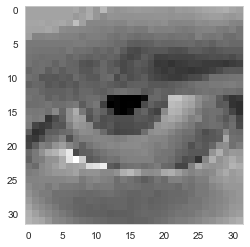

In [10]:
plt.imshow(x_train[4], cmap='gray')
print(y_train[4])
print(x_train.shape)

Neural Network

In [30]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import cv2

In [31]:
x_train = x_train.reshape(x_train.shape[0],32,32,1)
x_test = x_test.reshape(x_test.shape[0],32,32,1)
print(x_train.shape)
print(x_test.shape)

(40000, 32, 32, 1)
(10000, 32, 32, 1)


In [46]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(6, (5,5), activation='sigmoid', input_shape=(32,32,1)))
model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(16, (5,5), activation='sigmoid'))
model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(120, activation='sigmoid'))
model.add(tf.keras.layers.Dense(84, activation='sigmoid'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_10 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_11 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_16 (Dense)             (None, 84)               

In [47]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
test = model.fit(x_train, y_train, epochs=10)

Epoch 1/10
1250/1250 [==============================] - 7s 6ms/step - loss: 1.4333 - accuracy: 0.4273
Epoch 2/10
1250/1250 [==============================] - 7s 5ms/step - loss: 1.0024 - accuracy: 0.5774
Epoch 3/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.8571 - accuracy: 0.6368
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.7788 - accuracy: 0.6689
Epoch 5/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.7342 - accuracy: 0.6872
Epoch 6/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.6931 - accuracy: 0.7050
Epoch 7/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.6626 - accuracy: 0.7163
Epoch 8/10
1250/1250 [==============================] - 7s 6ms/step - loss: 0.6348 - accuracy: 0.7285
Epoch 9/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.6111 - accuracy: 0.7407
Epoch 10/10
1250/1250 [==============================] - ETA: 0s - loss: 0.5907 - 

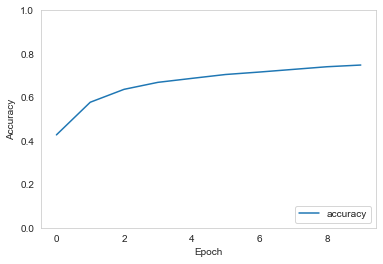

In [48]:
plt.plot(test.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.savefig("results.jpg")

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(x_test)
result = np.zeros(predictions.shape[0])
for i in range(predictions.shape[0]):
    result[i] = np.argmax(predictions[i])
new = y_test.flatten()
print(confusion_matrix(new,result))
print(classification_report(new,result))

[[ 401  126    4    3    0    3    0    0    2    0]
 [  83 1313  188   16    0    7    1    0    3    0]
 [   4  144 1068  274    6   15    0    1    4    0]
 [   0    7  129 1082  146   45    1    2    1    0]
 [   0    4    3  112  578  253    3    3    3    1]
 [   0    1    1    5   38  743   80   15    4    0]
 [   0    0    1    0    2  215  497  129   15    0]
 [   0    0    0    1    0   17   84  689  101    2]
 [   0    0    0    0    0   10    1  148  700   24]
 [   0    0    0    1    0    1    0    6  173  257]]
             precision    recall  f1-score   support

          0       0.82      0.74      0.78       539
          1       0.82      0.82      0.82      1611
          2       0.77      0.70      0.73      1516
          3       0.72      0.77      0.74      1413
          4       0.75      0.60      0.67       960
          5       0.57      0.84      0.68       887
          6       0.75      0.58      0.65       859
          7       0.69      0.77      0.73  

Export CNN for usage in coreML

In [50]:
model.save('GazeCNN.h5')

In [51]:
from tensorflow.keras.models import load_model
temp = load_model('GazeCNN.h5')
predictions = temp.predict(x_test)
result = np.zeros(predictions.shape[0])
for i in range(predictions.shape[0]):
    result[i] = np.argmax(predictions[i])
new = y_test.flatten()
print(confusion_matrix(new,result))
print(classification_report(new,result))

[[ 401  126    4    3    0    3    0    0    2    0]
 [  83 1313  188   16    0    7    1    0    3    0]
 [   4  144 1068  274    6   15    0    1    4    0]
 [   0    7  129 1082  146   45    1    2    1    0]
 [   0    4    3  112  578  253    3    3    3    1]
 [   0    1    1    5   38  743   80   15    4    0]
 [   0    0    1    0    2  215  497  129   15    0]
 [   0    0    0    1    0   17   84  689  101    2]
 [   0    0    0    0    0   10    1  148  700   24]
 [   0    0    0    1    0    1    0    6  173  257]]
             precision    recall  f1-score   support

          0       0.82      0.74      0.78       539
          1       0.82      0.82      0.82      1611
          2       0.77      0.70      0.73      1516
          3       0.72      0.77      0.74      1413
          4       0.75      0.60      0.67       960
          5       0.57      0.84      0.68       887
          6       0.75      0.58      0.65       859
          7       0.69      0.77      0.73  

In [63]:
import coremltools
GazeCNN = coremltools.convert(model)
GazeCNN.short_description = 'Gaze Recognition CNN'
GazeCNN.save('GazeCNN.mlmodel')

Translating MIL ==> MLModel Ops: 100%|██████████| 45/45 [00:00<00:00, 819.12 ops/s]
